# Exploring and Visualizing OpenAQ Data

In [2]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import openaq
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl
sns.set_theme(style="darkgrid")

from shapely.geometry import Point

import geopandas as gpd
from geopandas import GeoDataFrame

import geoplot as gplt
import geoplot.crs as gcrs

import fiona

In this project, we analyze open air quality data with py-openaq, which provides an easy-to-use interface for the OpenAQ API. Specifically, we look into the AQI trends of San Francisco and Los Angeles.

In [3]:
api = openaq.OpenAQ()
resp = api.cities(df=True, limit=10000)

In [5]:
resp.query('city.str.contains("San") and country.str.contains("US")', engine='python')

,country,name,city,count,locations
145,US,Atlanta-Sandy Springs-Marietta,Atlanta-Sandy Springs-Marietta,1904445,13
1383,US,Los Angeles-Long Beach-Santa Ana,Los Angeles-Long Beach-Santa Ana,5563326,32
2028,US,Riverside-San Bernardino-Ontario,Riverside-San Bernardino-Ontario,5439318,42
2094,US,San Antonio,San Antonio,514007,8
2102,US,San Diego-Carlsbad-San Marcos,San Diego-Carlsbad-San Marcos,1007147,11
2108,US,San Francisco Bay Area,San Francisco Bay Area,152929,1
2109,US,San Francisco-Oakland-Fremont,San Francisco-Oakland-Fremont,4656610,15
2111,US,San Jose-Sunnyvale-Santa Clara,San Jose-Sunnyvale-Santa Clara,1312746,8
2114,US,San Juan-Caguas-Guaynabo,San Juan-Caguas-Guaynabo,8475,1
2121,US,San Luis Obispo-Paso Robles,San Luis Obispo-Paso Robles,1613072,34


## Mapping Cities in SF Bay Area and LA Area

After querying into the dataset, we map the points in the San Francisco-Oakland-Fremont area that are included in the queried dataframe.

In [6]:
res = api.locations(city='San Francisco-Oakland-Fremont', df=True)

<AxesSubplot:>

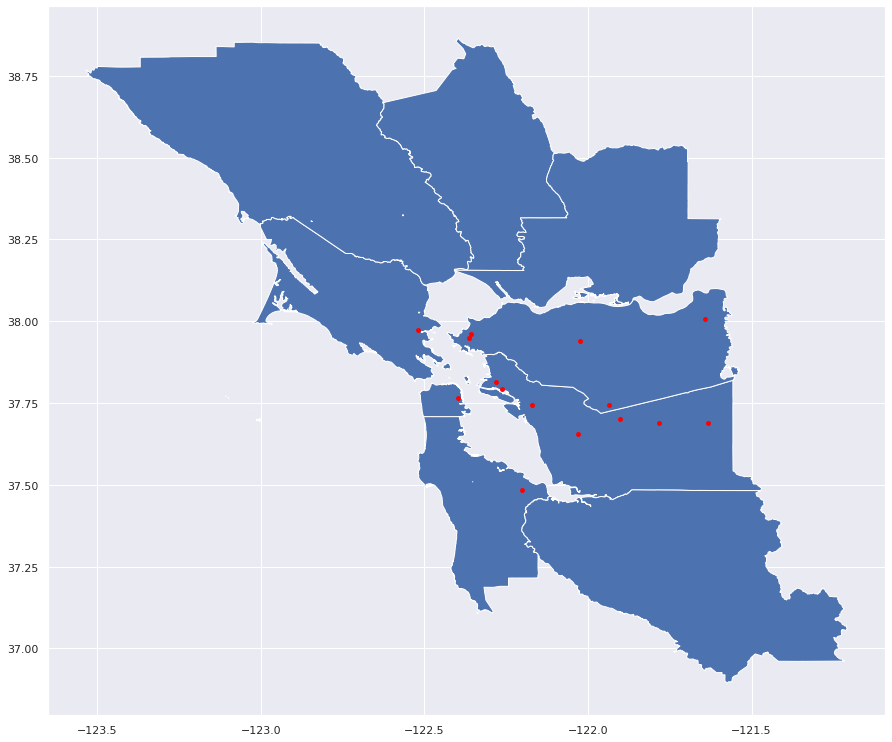

In [187]:
geometry = [Point(xy) for xy in zip(res['coordinates.longitude'], res['coordinates.latitude'])]
gdf = GeoDataFrame(res, geometry=geometry)
world = gpd.read_file("https://data.sfgov.org/api/geospatial/s9wg-vcph?method=export&format=Shapefile")
gdf.plot(ax=world.plot(figsize=(15, 15)), marker='o', color='red', markersize=15)

We do the same here for the Los Angeles-Long Beach-Santa Ana area.

In [4]:
resp.query('city.str.contains("Los Angeles") and country.str.contains("US")', engine='python')

,country,name,city,count,locations
1381,US,Los Angeles,Los Angeles,354,1
1383,US,Los Angeles-Long Beach-Santa Ana,Los Angeles-Long Beach-Santa Ana,5563494,32


In [7]:
la = api.locations(city='Los Angeles-Long Beach-Santa Ana', df=True)

<AxesSubplot:>

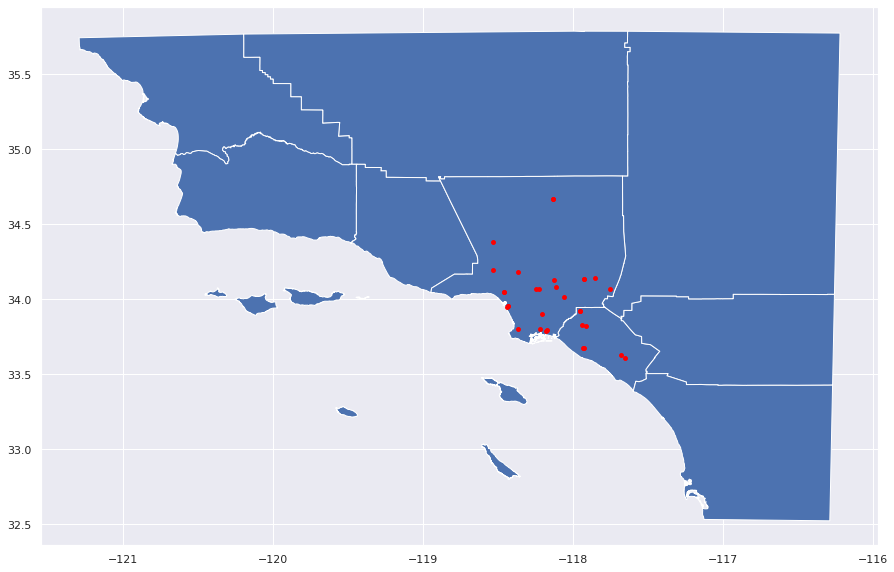

In [9]:
geometry = [Point(xy) for xy in zip(la['coordinates.longitude'], la['coordinates.latitude'])]
gdf = GeoDataFrame(la, geometry=geometry)
world = gpd.read_file("https://public.gis.lacounty.gov/public/rest/services/LACounty_Dynamic/Political_Boundaries/MapServer/18/query?outFields=*&where=1%3D1&f=geojson")
gdf.plot(ax=world.plot(figsize=(15, 15)), marker='o', color='red', markersize=15)

In [11]:
measure = api.measurements(city='San Francisco-Oakland-Fremont', parameter='pm25', limit=1000, df=True)

# Print out the statistics on a per-location basiss
measure.groupby(['location'])['value'].describe()

,count,mean,std,min,25%,50%,75%,max
location,,,,,,,,
Concord,102.0,5.294118,2.369728,-1.0,4.0,5.0,7.0,11.0
Laney College,70.0,5.685714,2.287603,0.0,4.0,6.0,7.0,10.0
Livermore - Rincon,106.0,5.132075,2.556320,0.0,3.0,5.0,7.0,12.0
Oakland,103.0,5.815534,2.099242,1.0,4.0,6.0,7.0,11.0
Oakland West,105.0,4.809524,2.357864,-1.0,3.0,5.0,7.0,11.0
Pleasanton - Owens C,102.0,5.588235,2.762381,-1.0,4.0,5.0,7.0,14.0
Redwood City,104.0,4.048077,3.095188,-3.0,2.0,4.0,5.0,15.0
San Francisco,104.0,5.586538,3.293449,-1.0,3.0,6.0,8.0,17.0
San Pablo - Rumrill,99.0,10.414141,8.164145,3.0,6.0,8.0,10.5,43.0


In [12]:
la_measure = api.measurements(city='Los Angeles-Long Beach-Santa Ana', parameter='pm25', limit=1000, df=True)

# Print out the statistics on a per-location basiss
la_measure.groupby(['location'])['value'].describe()

,count,mean,std,min,25%,50%,75%,max
location,,,,,,,,
Anaheim,99.0,11.341414,4.326803,4.1,8.500,10.00,12.30,26.1
Compton,96.0,13.839583,4.498666,7.8,10.800,12.70,15.50,28.9
Glendora - Laurel,98.0,10.500000,4.586758,1.0,7.600,9.60,13.00,21.6
Lancaster-Division,112.0,9.116071,4.831849,3.0,6.000,8.00,11.00,41.0
Long Beach Signal Hi,98.0,11.514286,3.777606,5.4,8.800,10.95,13.00,22.0
Los Angeles - N. Mai,99.0,14.848485,5.063784,8.0,11.500,13.30,16.40,30.9
Mission Viejo,99.0,16.162626,4.485136,8.4,13.050,15.50,19.55,30.2
North Holywood,96.0,15.041667,4.338097,8.1,11.925,14.20,18.80,24.4
Reseda,99.0,13.576768,5.290998,3.1,9.950,12.20,16.80,32.1


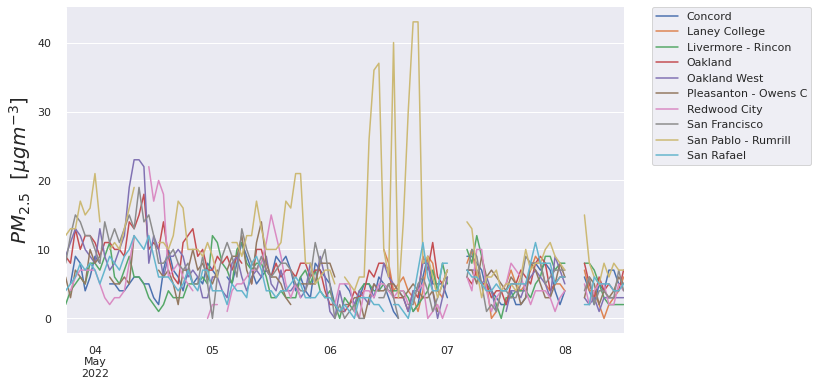

In [189]:
fig, ax = plt.subplots(1, figsize=(10, 6))

for group, df in measure.groupby('location'):
    # Query the data to only get positive values and resample to hourly
    _df = df.query("value >= 0.0").resample('1h').mean()

    _df.value.plot(ax=ax, label=group)

ax.legend(loc='best')
ax.set_ylabel("$PM_{2.5}$  [$\mu g m^{-3}$]", fontsize=20)
ax.set_xlabel("")
sns.despine(offset=5)

plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

plt.show()

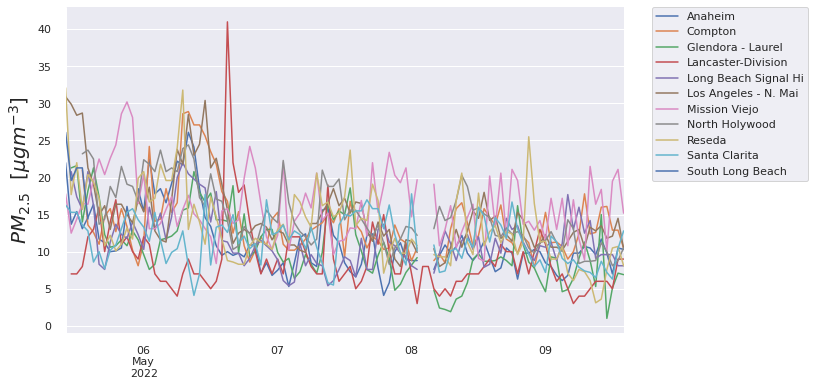

In [13]:
fig, ax = plt.subplots(1, figsize=(10, 6))

for group, df in la_measure.groupby('location'):
    # Query the data to only get positive values and resample to hourly
    _df = df.query("value >= 0.0").resample('1h').mean()

    _df.value.plot(ax=ax, label=group)

ax.legend(loc='best')
ax.set_ylabel("$PM_{2.5}$  [$\mu g m^{-3}$]", fontsize=20)
ax.set_xlabel("")
sns.despine(offset=5)

plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

plt.show()

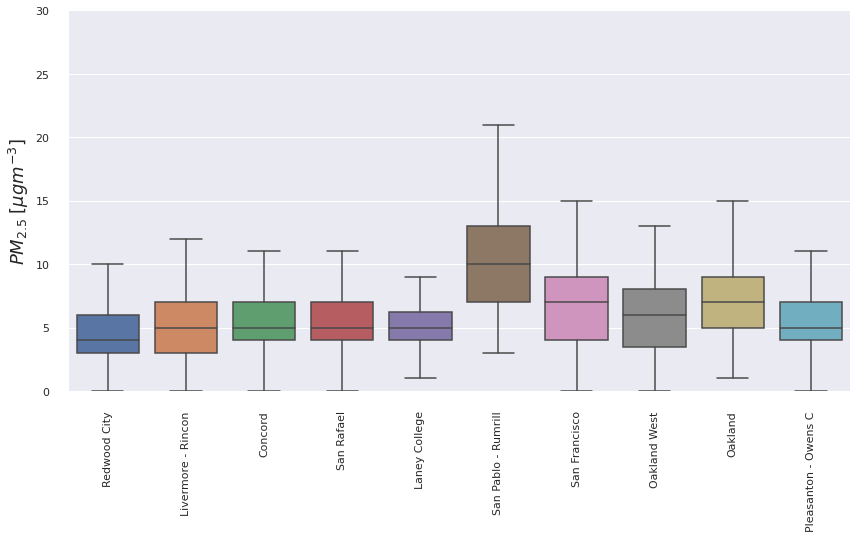

In [190]:
fig, ax = plt.subplots(1, figsize=(14,7))

ax = sns.boxplot(
    x='location',
    y='value',
    data=measure.query("value >= 0.0"),
    fliersize=0,
    palette='deep',
    ax=ax)

ax.set_ylim([0, 30])
ax.set_ylabel("$PM_{2.5}\;[\mu gm^{-3}]$", fontsize=18)
ax.set_xlabel("")

sns.despine(offset=10)

plt.xticks(rotation=90)
plt.show()

In [191]:
sanfrancisco = api.locations(city='San Francisco-Oakland-Fremont', df=True)


sanfrancisco.iloc[0]


id                                                                    1311
country                                                                 US
city                                         San Francisco-Oakland-Fremont
cities                                     [San Francisco-Oakland-Fremont]
location                                                     Laney College
locations                                                  [Laney College]
sourceName                                                          AirNow
sourceNames                                                       [AirNow]
sourceType                                                      government
sourceTypes                                                   [government]
firstUpdated                                     2016-03-06 19:00:00+00:00
lastUpdated                                      2022-05-08 19:00:00+00:00
parameters                                             [pm25, no2, co, bc]
countsByMeasurement      

In [192]:
dark_day_sf_pm25 = api.measurements(location='San Francisco', parameter='pm25', date_from='2020-09-07', date_to='2020-09-13', df=True, limit=1000)
dark_day_sf_pm25.head()

,location,parameter,value,unit,country,city,date.utc,coordinates.latitude,coordinates.longitude
date.local,,,,,,,,,
2020-09-12 17:00:00,San Francisco,pm25,77,b'\xc2\xb5g/m\xc2\xb3',US,San Francisco-Oakland-Fremont,2020-09-13 00:00:00+00:00,37.7658,-122.3978
2020-09-12 16:00:00,San Francisco,pm25,78,b'\xc2\xb5g/m\xc2\xb3',US,San Francisco-Oakland-Fremont,2020-09-12 23:00:00+00:00,37.7658,-122.3978
2020-09-12 15:00:00,San Francisco,pm25,77,b'\xc2\xb5g/m\xc2\xb3',US,San Francisco-Oakland-Fremont,2020-09-12 22:00:00+00:00,37.7658,-122.3978
2020-09-12 14:00:00,San Francisco,pm25,83,b'\xc2\xb5g/m\xc2\xb3',US,San Francisco-Oakland-Fremont,2020-09-12 21:00:00+00:00,37.7658,-122.3978
2020-09-12 13:00:00,San Francisco,pm25,87,b'\xc2\xb5g/m\xc2\xb3',US,San Francisco-Oakland-Fremont,2020-09-12 20:00:00+00:00,37.7658,-122.3978


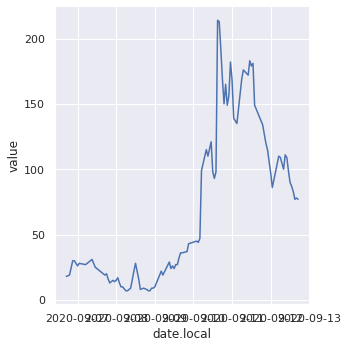

In [193]:
g = sns.relplot(x=dark_day_sf_pm25.index, y='value', kind='line', data=dark_day_sf_pm25)
#g.set(xticks=range(len(dark_day_sf_pm25.index)+1))

In [194]:
test = api.measurements(city='San Francisco-Oakland-Fremont', date_from='2020-09-07', date_to='2020-09-08', df=True, limit=1000)
test = test[test['parameter'] == 'pm25']
test = test[test['date.utc'] == '2020-09-07 13:00:00+00:00']
test

,location,parameter,value,unit,country,city,date.utc,coordinates.latitude,coordinates.longitude
date.local,,,,,,,,,
2020-09-07 06:00:00,Concord,pm25,21.0,b'\xc2\xb5g/m\xc2\xb3',US,San Francisco-Oakland-Fremont,2020-09-07 13:00:00+00:00,37.938300,-122.025000
2020-09-07 06:00:00,Laney College,pm25,21.0,b'\xc2\xb5g/m\xc2\xb3',US,San Francisco-Oakland-Fremont,2020-09-07 13:00:00+00:00,37.793624,-122.263376
2020-09-07 06:00:00,Livermore - Rincon,pm25,30.0,b'\xc2\xb5g/m\xc2\xb3',US,San Francisco-Oakland-Fremont,2020-09-07 13:00:00+00:00,37.687526,-121.784217
2020-09-07 06:00:00,Redwood City,pm25,30.0,b'\xc2\xb5g/m\xc2\xb3',US,San Francisco-Oakland-Fremont,2020-09-07 13:00:00+00:00,37.482800,-122.202200
2020-09-07 06:00:00,Oakland West,pm25,21.0,b'\xc2\xb5g/m\xc2\xb3',US,San Francisco-Oakland-Fremont,2020-09-07 13:00:00+00:00,37.814800,-122.282402
2020-09-07 06:00:00,San Rafael,pm25,18.0,b'\xc2\xb5g/m\xc2\xb3',US,San Francisco-Oakland-Fremont,2020-09-07 13:00:00+00:00,37.972200,-122.518900
2020-09-07 06:00:00,Oakland,pm25,21.0,b'\xc2\xb5g/m\xc2\xb3',US,San Francisco-Oakland-Fremont,2020-09-07 13:00:00+00:00,37.743061,-122.169907
2020-09-07 06:00:00,Pleasanton - Owens C,pm25,32.0,b'\xc2\xb5g/m\xc2\xb3',US,San Francisco-Oakland-Fremont,2020-09-07 13:00:00+00:00,37.701222,-121.903019
2020-09-07 06:00:00,San Pablo - Rumrill,pm25,16.0,b'\xc2\xb5g/m\xc2\xb3',US,San Francisco-Oakland-Fremont,2020-09-07 13:00:00+00:00,37.960400,-122.357100


In [195]:
geometry = [Point(xy) for xy in zip(test['coordinates.longitude'], test['coordinates.latitude'])]
gdf = GeoDataFrame(test, geometry=geometry)

gdf


,location,parameter,value,unit,country,city,date.utc,coordinates.latitude,coordinates.longitude,geometry
date.local,,,,,,,,,,
2020-09-07 06:00:00,Concord,pm25,21.0,b'\xc2\xb5g/m\xc2\xb3',US,San Francisco-Oakland-Fremont,2020-09-07 13:00:00+00:00,37.938300,-122.025000,POINT (-122.02500 37.93830)
2020-09-07 06:00:00,Laney College,pm25,21.0,b'\xc2\xb5g/m\xc2\xb3',US,San Francisco-Oakland-Fremont,2020-09-07 13:00:00+00:00,37.793624,-122.263376,POINT (-122.26338 37.79362)
2020-09-07 06:00:00,Livermore - Rincon,pm25,30.0,b'\xc2\xb5g/m\xc2\xb3',US,San Francisco-Oakland-Fremont,2020-09-07 13:00:00+00:00,37.687526,-121.784217,POINT (-121.78422 37.68753)
2020-09-07 06:00:00,Redwood City,pm25,30.0,b'\xc2\xb5g/m\xc2\xb3',US,San Francisco-Oakland-Fremont,2020-09-07 13:00:00+00:00,37.482800,-122.202200,POINT (-122.20220 37.48280)
2020-09-07 06:00:00,Oakland West,pm25,21.0,b'\xc2\xb5g/m\xc2\xb3',US,San Francisco-Oakland-Fremont,2020-09-07 13:00:00+00:00,37.814800,-122.282402,POINT (-122.28240 37.81480)
2020-09-07 06:00:00,San Rafael,pm25,18.0,b'\xc2\xb5g/m\xc2\xb3',US,San Francisco-Oakland-Fremont,2020-09-07 13:00:00+00:00,37.972200,-122.518900,POINT (-122.51890 37.97220)
2020-09-07 06:00:00,Oakland,pm25,21.0,b'\xc2\xb5g/m\xc2\xb3',US,San Francisco-Oakland-Fremont,2020-09-07 13:00:00+00:00,37.743061,-122.169907,POINT (-122.16991 37.74306)
2020-09-07 06:00:00,Pleasanton - Owens C,pm25,32.0,b'\xc2\xb5g/m\xc2\xb3',US,San Francisco-Oakland-Fremont,2020-09-07 13:00:00+00:00,37.701222,-121.903019,POINT (-121.90302 37.70122)
2020-09-07 06:00:00,San Pablo - Rumrill,pm25,16.0,b'\xc2\xb5g/m\xc2\xb3',US,San Francisco-Oakland-Fremont,2020-09-07 13:00:00+00:00,37.960400,-122.357100,POINT (-122.35710 37.96040)


Text(0.5, 1.0, 'Bay Area pm25 on ')

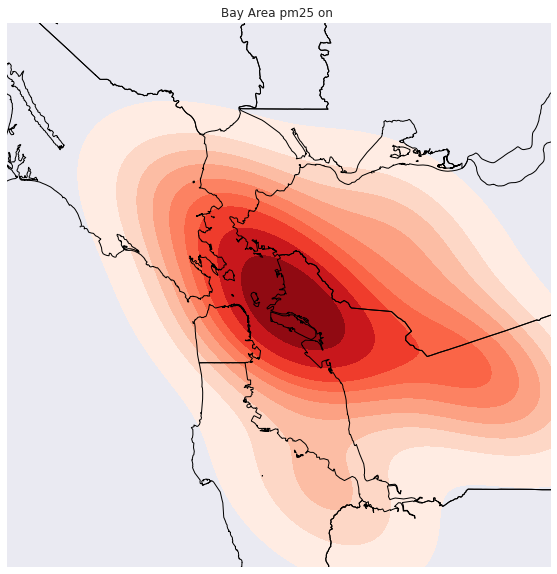

In [196]:
proj = gcrs.AlbersEqualArea(central_latitude=37.8711428, central_longitude=-122.3714777)
fig= plt.figure(figsize=(10, 10))
ax1 = plt.subplot(111, projection=proj)

gplt.kdeplot(
    gdf,
    cmap='Reds',
    projection=proj,
    shade=True, thresh=0.05,
    ax=ax1
)
gplt.polyplot(world, zorder=1, ax=ax1)
ax1.axis(xmin=-50000,xmax=60000, ymin=-60000, ymax=50000)
ax1.set_title("Bay Area pm25 on ")

In [278]:
USlocs = api.locations(country='US', df=True, limit=10000)

USlocs.head()

,id,country,city,cities,location,locations,sourceName,sourceNames,sourceType,sourceTypes,firstUpdated,lastUpdated,parameters,countsByMeasurement,count,coordinates.latitude,coordinates.longitude
0,212,US,Fort Smith,[Fort Smith],ROLAND,[ROLAND],AirNow,[AirNow],government,[government],2016-03-06 19:00:00+00:00,2022-05-08 20:00:00+00:00,"[o3, pm10, no2, pm25]","[{'parameter': 'o3', 'count': 71194}, {'parame...",204682,35.408138,-94.524414
1,213,US,TWIN FALLS,[TWIN FALLS],Twin Falls PM25,"[Twin Falls 1405 TEOM, Twin Falls PM25]",AirNow,[AirNow],government,[government],2016-03-06 19:00:00+00:00,2022-05-08 20:00:00+00:00,[pm25],"[{'parameter': 'pm25', 'count': 103961}]",103961,42.565089,-114.494717
2,216,US,South Bend-Mishawaka,[South Bend-Mishawaka],South Bend-Shields D,[South Bend-Shields D],AirNow,[AirNow],government,[government],2016-03-06 19:00:00+00:00,2022-05-08 20:00:00+00:00,"[pm25, o3, no2]","[{'parameter': 'pm25', 'count': 40288}, {'para...",212674,41.696700,-86.214700
3,218,US,Chicago-Naperville-Joliet,[Chicago-Naperville-Joliet],Ogden Dunes,[Ogden Dunes],AirNow,[AirNow],government,[government],2016-03-13 05:00:00+00:00,2022-05-08 20:00:00+00:00,"[o3, pm25]","[{'parameter': 'o3', 'count': 89372}, {'parame...",89373,41.617500,-87.199200
4,220,US,WHITLEY,[WHITLEY],Larwill,[Larwill],AirNow,[AirNow],government,[government],2016-03-06 19:00:00+00:00,2022-05-08 20:00:00+00:00,"[pm25, no2, so2]","[{'parameter': 'pm25', 'count': 18980}, {'para...",23728,41.169722,-85.629444


In [279]:
filter1 = USlocs[USlocs['coordinates.latitude'] > 37.]
filter2= filter1[filter1['coordinates.latitude'] < 38.]
filter3 = filter2[filter2['coordinates.longitude'] < -121.3]
filter4 = filter3[filter3['coordinates.longitude'] > -123.]
filter5 = filter4[filter4['firstUpdated'] < '2020-09-07 00:00:00+00:00']
bay_area_locs = filter5[filter5['lastUpdated'] > '2020-09-13 00:00:00+00:00']
bay_area_locs

,id,country,city,cities,location,locations,sourceName,sourceNames,sourceType,sourceTypes,firstUpdated,lastUpdated,parameters,countsByMeasurement,count,coordinates.latitude,coordinates.longitude
212,793,US,Stockton,[Stockton],TracyAP,[TracyAP],AirNow,[AirNow],government,[government],2016-03-10 07:00:00+00:00,2022-05-08 20:00:00+00:00,"[no2, o3, pm10, pm25]","[{'parameter': 'no2', 'count': 64727}, {'param...",310245,37.682500,-121.440600
490,1311,US,San Francisco-Oakland-Fremont,[San Francisco-Oakland-Fremont],Laney College,[Laney College],AirNow,[AirNow],government,[government],2016-03-06 19:00:00+00:00,2022-05-08 20:00:00+00:00,"[bc, co, no2, pm25]","[{'parameter': 'bc', 'count': 98338}, {'parame...",381868,37.793624,-122.263376
621,1518,US,San Francisco-Oakland-Fremont,[San Francisco-Oakland-Fremont],Livermore - Rincon,[Livermore - Rincon],AirNow,[AirNow],government,[government],2016-03-06 19:00:00+00:00,2022-05-08 20:00:00+00:00,"[o3, no2, pm25, bc]","[{'parameter': 'o3', 'count': 92515}, {'parame...",372564,37.687526,-121.784217
660,1577,US,San Jose-Sunnyvale-Santa Clara,[San Jose-Sunnyvale-Santa Clara],Los Gatos,[Los Gatos],AirNow,[AirNow],government,[government],2016-04-01 17:00:00+00:00,2022-05-08 20:00:00+00:00,[o3],"[{'parameter': 'o3', 'count': 91075}]",91075,37.226700,-121.978600
898,1950,US,San Francisco-Oakland-Fremont,[San Francisco-Oakland-Fremont],Concord,[Concord],AirNow,[AirNow],government,[government],2016-03-06 19:00:00+00:00,2022-05-08 20:00:00+00:00,"[co, so2, no2, pm25, o3]","[{'parameter': 'co', 'count': 91397}, {'parame...",457414,37.938300,-122.025000
930,2001,US,San Francisco-Oakland-Fremont,[San Francisco-Oakland-Fremont],San Ramon,[San Ramon],AirNow,[AirNow],government,[government],2016-04-01 17:00:00+00:00,2022-05-08 20:00:00+00:00,"[o3, no2]","[{'parameter': 'o3', 'count': 93448}, {'parame...",186695,37.743649,-121.934188
931,2002,US,San Francisco-Oakland-Fremont,[San Francisco-Oakland-Fremont],San Rafael,[San Rafael],AirNow,[AirNow],government,[government],2016-03-06 19:00:00+00:00,2022-05-08 20:00:00+00:00,"[pm25, co, no2, o3]","[{'parameter': 'pm25', 'count': 96988}, {'para...",371916,37.972200,-122.518900
932,2003,US,San Francisco-Oakland-Fremont,[San Francisco-Oakland-Fremont],San Pablo - Rumrill,[San Pablo - Rumrill],AirNow,[AirNow],government,[government],2016-03-06 19:00:00+00:00,2022-05-08 20:00:00+00:00,"[no2, co, so2, pm25, o3]","[{'parameter': 'no2', 'count': 88401}, {'param...",451560,37.960400,-122.357100
933,2004,US,San Jose-Sunnyvale-Santa Clara,[San Jose-Sunnyvale-Santa Clara],San Martin,[San Martin],AirNow,[AirNow],government,[government],2016-04-01 17:00:00+00:00,2022-05-08 20:00:00+00:00,[o3],"[{'parameter': 'o3', 'count': 90146}]",90146,37.079200,-121.599400
934,2007,US,San Jose-Sunnyvale-Santa Clara,[San Jose-Sunnyvale-Santa Clara],San Jose - Knox Ave,[San Jose - Knox Ave],AirNow,[AirNow],government,[government],2016-03-06 19:00:00+00:00,2022-05-08 20:00:00+00:00,"[no2, bc, co, pm25]","[{'parameter': 'no2', 'count': 93705}, {'param...",380417,37.338202,-121.849892


In [280]:
city_list = bay_area_locs.reset_index()
dark_days_data = {}
for index, row in city_list.iterrows():
    location = row['location']
    coords = (row['coordinates.longitude'], row['coordinates.latitude'])
    if row['parameters'].count('pm25') == 0:
        continue
    if row['city'] == 'Santa Cruz-Watsonville':
        continue
    table = api.measurements(location=location, parameter='pm25', 
                             date_from='2020-09-07', date_to='2020-09-13', df=True, limit=1000)
    table = table.reset_index()
    date_vals = dict(list(zip(table['date.local'], table['value'])))
    dark_days_data[location] = list()
    dark_days_data[location].append(coords)
    dark_days_data[location].append(date_vals)
    print(location)

TracyAP
Laney College
Livermore - Rincon
Concord
San Rafael
San Pablo - Rumrill
San Jose - Knox Ave
San Jose - Jackson S
San Francisco
Oakland
Oakland West
Redwood City
Pleasanton - Owens C
Berkeley Aquatic Par


In [240]:
df = pd.DataFrame.from_dict(dark_days_data['TracyAP'][1], orient='index', columns=['TracyAP'])
for key in dark_days_data.keys():
    df2 = pd.DataFrame.from_dict(dark_days_data[key][1], orient='index', columns=[key])
    df = pd.concat([df, df2], axis=1)
df = df.iloc[: , 1:]
df.head()

,TracyAP,Laney College,Livermore - Rincon,Concord,San Rafael,San Pablo - Rumrill,San Jose - Knox Ave,San Jose - Jackson S,San Francisco,Oakland,Oakland West,Redwood City,Pleasanton - Owens C,Berkeley Aquatic Par
2020-09-06 17:00:00,61.0,37.0,71.0,68.0,25.0,43.0,73.0,83.0,18.0,39.0,26.0,60.0,58.0,27.0
2020-09-06 19:00:00,NaN,29.0,62.0,24.0,15.0,39.0,41.0,27.0,19.0,35.0,23.0,39.0,54.0,22.0
2020-09-06 21:00:00,47.0,23.0,56.0,29.0,15.0,38.0,44.0,45.0,30.0,44.0,19.0,27.0,45.0,25.0
2020-09-06 22:00:00,NaN,20.0,41.0,30.0,10.0,25.0,51.0,51.0,30.0,44.0,22.0,38.0,53.0,22.0
2020-09-07 00:00:00,NaN,28.0,40.0,25.0,20.0,25.0,54.0,52.0,26.0,34.0,25.0,42.0,47.0,30.0


In [241]:
df = df.interpolate(method='linear', limit_direction='forward', axis=0)
df.head()

,TracyAP,Laney College,Livermore - Rincon,Concord,San Rafael,San Pablo - Rumrill,San Jose - Knox Ave,San Jose - Jackson S,San Francisco,Oakland,Oakland West,Redwood City,Pleasanton - Owens C,Berkeley Aquatic Par
2020-09-06 17:00:00,61.000000,37.0,71.0,68.0,25.0,43.0,73.0,83.0,18.0,39.0,26.0,60.0,58.0,27.0
2020-09-06 19:00:00,54.000000,29.0,62.0,24.0,15.0,39.0,41.0,27.0,19.0,35.0,23.0,39.0,54.0,22.0
2020-09-06 21:00:00,47.000000,23.0,56.0,29.0,15.0,38.0,44.0,45.0,30.0,44.0,19.0,27.0,45.0,25.0
2020-09-06 22:00:00,47.333333,20.0,41.0,30.0,10.0,25.0,51.0,51.0,30.0,44.0,22.0,38.0,53.0,22.0
2020-09-07 00:00:00,47.666667,28.0,40.0,25.0,20.0,25.0,54.0,52.0,26.0,34.0,25.0,42.0,47.0,30.0


In [272]:
df.size

1568

In [257]:
name_list = []
coord_list = []
for key in dark_days_data.keys():
    name_list.append(key)
    coord_list.append(dark_days_data[key][0])

geometry = [Point(xy) for xy in coord_list]
cities_coords = GeoDataFrame(name_list, geometry=geometry)
cities_coords

,0,geometry
0,TracyAP,POINT (-121.44060 37.68250)
1,Laney College,POINT (-122.26338 37.79362)
2,Livermore - Rincon,POINT (-121.78422 37.68753)
3,Concord,POINT (-122.02500 37.93830)
4,San Rafael,POINT (-122.51890 37.97220)
5,San Pablo - Rumrill,POINT (-122.35710 37.96040)
6,San Jose - Knox Ave,POINT (-121.84989 37.33820)
7,San Jose - Jackson S,POINT (-121.89470 37.34830)
8,San Francisco,POINT (-122.39780 37.76580)
9,Oakland,POINT (-122.16991 37.74306)


In [286]:
temp = cities_coords.set_index([0])
for i in range(df.shape[0]):
    dftemp =  pd.DataFrame(df.iloc[i])
    temp = pd.concat([temp, dftemp], axis=1)
bay_area_dark_days_data = temp


,geometry,2020-09-06 17:00:00,2020-09-06 19:00:00,2020-09-06 21:00:00,2020-09-06 22:00:00,2020-09-07 00:00:00,2020-09-07 01:00:00,2020-09-07 03:00:00,2020-09-07 05:00:00,2020-09-07 06:00:00,...,2020-09-12 08:00:00,2020-09-12 09:00:00,2020-09-12 10:00:00,2020-09-12 11:00:00,2020-09-12 12:00:00,2020-09-12 13:00:00,2020-09-12 14:00:00,2020-09-12 15:00:00,2020-09-12 16:00:00,2020-09-12 17:00:00
TracyAP,POINT (-121.44060 37.68250),61.0,54.0,47.0,47.333333,47.666667,48.000000,29.000000,22.0,24.0,...,62.0,84.0,102.0,100.666667,99.333333,98.0,109.0,108.0,135.5,163.0
Laney College,POINT (-122.26338 37.79362),37.0,29.0,23.0,20.000000,28.000000,26.000000,23.500000,21.0,21.0,...,113.0,123.0,127.0,116.000000,111.000000,105.0,99.0,89.0,74.0,84.0
Livermore - Rincon,POINT (-121.78422 37.68753),71.0,62.0,56.0,41.000000,40.000000,41.000000,38.500000,36.0,30.0,...,100.0,111.0,105.0,102.000000,101.000000,103.0,109.0,161.0,162.0,176.0
Concord,POINT (-122.02500 37.93830),68.0,24.0,29.0,30.000000,25.000000,26.000000,24.500000,23.0,21.0,...,97.0,101.0,110.0,107.000000,113.000000,112.0,118.0,127.0,132.0,183.0
San Rafael,POINT (-122.51890 37.97220),25.0,15.0,15.0,10.000000,20.000000,16.000000,17.000000,18.0,18.0,...,95.0,106.0,107.0,103.000000,98.000000,103.0,113.0,102.0,109.0,87.0
San Pablo - Rumrill,POINT (-122.35710 37.96040),43.0,39.0,38.0,25.000000,25.000000,22.000000,24.000000,26.0,16.0,...,103.0,109.0,106.0,107.000000,110.000000,103.0,102.0,90.0,83.0,92.0
San Jose - Knox Ave,POINT (-121.84989 37.33820),73.0,41.0,44.0,51.000000,54.000000,56.000000,55.500000,55.0,50.0,...,130.0,129.0,131.0,123.000000,102.000000,99.0,92.0,89.0,91.0,90.0
San Jose - Jackson S,POINT (-121.89470 37.34830),83.0,27.0,45.0,51.000000,52.000000,49.000000,48.000000,47.0,38.0,...,117.0,123.0,117.0,124.000000,119.000000,103.0,99.0,91.0,99.0,94.0
San Francisco,POINT (-122.39780 37.76580),18.0,19.0,30.0,30.000000,26.000000,28.000000,27.500000,27.0,28.0,...,100.0,111.0,109.0,99.000000,90.000000,87.0,83.0,77.0,78.0,77.0
Oakland,POINT (-122.16991 37.74306),39.0,35.0,44.0,44.000000,34.000000,31.333333,28.666667,26.0,21.0,...,100.0,114.0,115.0,110.000000,115.000000,113.0,102.0,100.0,85.0,92.0


In [292]:
bay_area_dark_days_data_text = bay_area_dark_days_data
bay_area_dark_days_data_text.columns = bay_area_dark_days_data_text.columns.astype(str)
bay_area_dark_days_data_text.to_file('bayareadarkdays.geojson', driver='GeoJSON')  

In [294]:
#gpd.read_file('bayareadarkdays.geojson')

Text(0.5, 1.0, 'Bay Area pm25 on ')

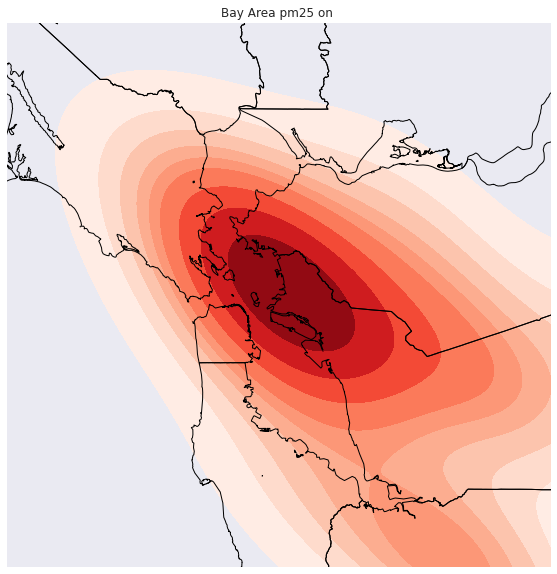

In [276]:
proj = gcrs.AlbersEqualArea(central_latitude=37.8711428, central_longitude=-122.3714777)
fig= plt.figure(figsize=(10, 10))
ax1 = plt.subplot(111, projection=proj)

gplt.kdeplot(
    trial1,
    cmap='Reds',
    projection=proj,
    shade=True, thresh=0.05,
    ax=ax1
)
gplt.polyplot(world, zorder=1, ax=ax1)
ax1.axis(xmin=-50000,xmax=60000, ymin=-60000, ymax=50000)
ax1.set_title("Bay Area pm25 on ")

Text(0.5, 1.0, 'Bay Area pm25 on ')

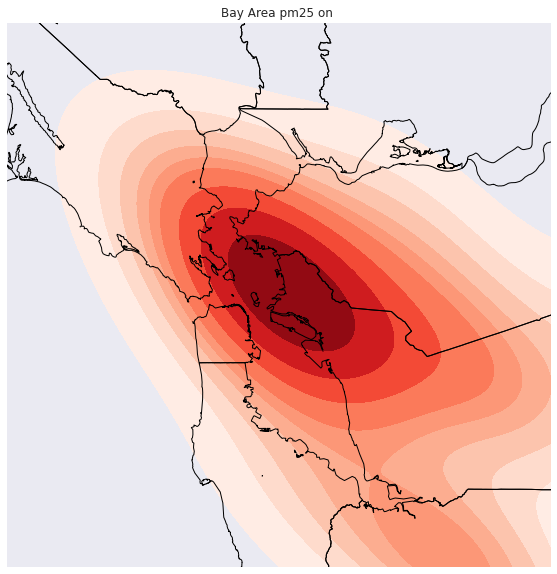

In [277]:
proj = gcrs.AlbersEqualArea(central_latitude=37.8711428, central_longitude=-122.3714777)
fig= plt.figure(figsize=(10, 10))
ax1 = plt.subplot(111, projection=proj)

gplt.kdeplot(
    trial2,
    cmap='Reds',
    projection=proj,
    shade=True, thresh=0.05,
    ax=ax1
)
gplt.polyplot(world, zorder=1, ax=ax1)
ax1.axis(xmin=-50000,xmax=60000, ymin=-60000, ymax=50000)
ax1.set_title("Bay Area pm25 on ")